# Project: 使用中值滤波对图像进行降噪处理
# 01: OpenCV 中值滤波

## 检查Lena的图片 
我们首先导入OpenCV-Python库用作图像处理，matplotlib库用作绘图。

In [44]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

我们可以通过`imread`方法读取jpg格式的图片，原图是一张400x400大小的三通道的图片。

In [45]:
img = cv2.imread("./lena.jpg")
print("原始图像尺寸：{}".format(img.shape))

原始图像尺寸：(400, 400, 3)


通过`imshow`方法进行图片显示。

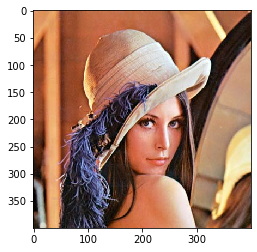

In [46]:
plt.imshow(img[:,:,::-1])

### RGB图转灰度图
将RGB图像转为灰度图，便于后续进行处理及观察。

In [47]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print("灰度图尺寸：{}".format(gray.shape))

灰度图尺寸：(400, 400)


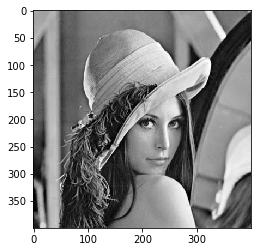

In [48]:
plt.imshow(gray,cmap='gray')

### 在图片上添加随机噪声
使用random随机函数，在图像上随机添加噪声点(随机在图像上将像素点的灰度值变为255)。

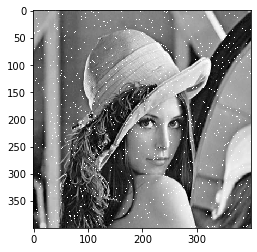

In [49]:
def random_noise(image,noise_num):
    img_noise = image
    rows, cols = img_noise.shape
    # 加噪声
    for i in range(noise_num):
        x = np.random.randint(0, rows)  #随机生成指定范围的整数
        y = np.random.randint(0, cols)
        img_noise[x, y] = 255
    return img_noise

img_noise = random_noise(gray, 3000)
plt.imshow(img_noise,cmap='gray')

### 使用OpenCV中值滤波对图片进行降噪处理

In [50]:
import time

start_time = time.time()

img_median = cv2.medianBlur(img_noise, 5)

end_time = time.time()

print("耗时：{}s".format(end_time - start_time))

耗时：0.060645103454589844s


绘制处理后的图像。

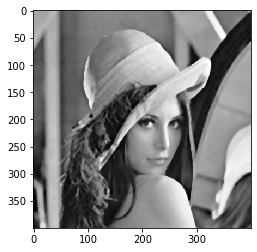

In [51]:
plt.imshow(img_median,cmap='gray')

# 02:  Hardware 中值滤波
## 方式1：直接调用

### 载入Overlay

将硬件设计部署到板卡上，根据图片尺寸分配内存，并将图像复制到对应位置。

In [52]:
from pynq import Overlay, allocate

overlay = Overlay("./overlay_axis/filter.bit")

filter = overlay.filter_0

In [53]:
# allocate memory
rows, cols= gray.shape
input_buffer = allocate(shape=(rows*cols,), dtype='u1')
output_buffer = allocate(shape=(rows*cols,), dtype='u1')

# input
noise_new = np.uint8(img_noise)
np.copyto(input_buffer, noise_new.flatten())

### 写入参数
在IP上写入值时，根据HLS给出的IP Driver Source Code直接在对应位置写入：

In [54]:
filter.write(0x10, rows)
filter.write(0x18, cols)

由于提供了`filter.hwh`文件，`filter`对象已经包含了Register Map并将其暴露出来，我们可以直接打印查看各寄存器的信息：

In [55]:
filter.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  rows = Register(rows=write-only),
  cols = Register(cols=write-only)
}

我们也可以直接在Register Map中与其交互，而不需要去手动输入对应的地址：

In [56]:
filter.register_map.rows = rows
filter.register_map.cols = cols

### 启动IP

将IP中的DMA对象提取出来。

In [57]:
dma = overlay.axi_dma_0

filter IP 使用了AXI Stream的接口格式。
- 我们需要调用DMA读取输入缓冲，并将数据发送到AXI Stream Master
- 之后，DMA应从AXI Stream Slave中将结果写回到输出缓冲中
- `wait`语句确保了DMA的处理操作已经完成

In [58]:
import time

filter.register_map.CTRL.AP_START = 1

start_time = time.time()

dma.sendchannel.transfer(input_buffer)
dma.recvchannel.transfer(output_buffer)
dma.sendchannel.wait() # wait for send channel
dma.recvchannel.wait() # wait for recv channel

end_time = time.time()

print("耗时：{}s".format(end_time - start_time))

耗时：0.008859634399414062s


将结果进行可视化。

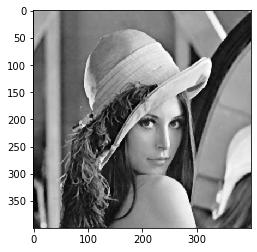

In [59]:
plt.imshow(output_buffer.reshape(rows, cols),cmap='gray')

## 方式2：为IP创建一个Driver
创建一个用户有好的API将是我们的下一步，我们希望可以创建一个对于特定IP的驱动程序。
- 公开单个的`filter3x3`函数来调用加速器
- 继承pynq的`DeafaultIP`

In [60]:
from pynq import DefaultIP

class FilterDriver(DefaultIP):
    def __init__(self, description):
        super().__init__(description=description)

    bindto = ['xilinx.com:hls:filter:1.0']

    def filter3x3(self, imgi, imgo, rows, cols):      
        
        self.write(0x10, rows)
        self.write(0x18, cols)
        self.register_map.CTRL.AP_START = 1
        
        dma.sendchannel.transfer(imgi)
        dma.recvchannel.transfer(imgo)
        dma.sendchannel.wait() # wait for send channel
        dma.recvchannel.wait() # wait for recv channel
        
        res = imgo.reshape(rows, cols)
        return res

重新载入Overlay使得更改生效：

In [61]:
overlay = Overlay("./overlay_axis/filter.bit")
dma = overlay.axi_dma_0
filter = overlay.filter_0

现在，我们可以直接调用上方描述的`filter3x3`方法：

In [62]:
res = filter.filter3x3(input_buffer, output_buffer, rows, cols)

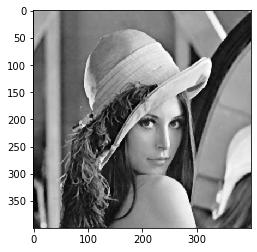

In [63]:
plt.imshow(res,cmap='gray')